In [1]:
import math

import torch
import torch.nn as nn
import torch.distributions as dist

from torch import Tensor
from torch.distributions import Distribution

In [2]:
# "Abstract" classes: roughly how these should look like. The methods that
# raise Not Implemented errors must be implemented for each specific model
# (example with a simple linear model given below)

class SimulatorBasedModel(nn.Module):
  def __init__(self, prior: Distribution, design_net: nn.Module, T: int) -> None:
    super().__init__()
    self.prior = prior
    self.design_net = design_net
    self.T = T

  def outcome_simulator(self, params: Tensor, designs: Tensor) -> Tensor:
    raise NotImplemented

  def forward(self, batch_size: int | None = None) -> tuple[Tensor, Tensor, Tensor]: # call
    prior_params = self.prior.sample(torch.Size([batch_size])) # [B, param_dim]
    designs = []
    outcomes = []
    for t in range(self.T):
      # get design:
      xi = self.design_net(designs, outcomes)
      y = self.outcome_simulator(params=prior_params, designs=xi)

      designs.append(xi)
      outcomes.append(y)

    return prior_params, designs, outcomes

class LikelihoodBasedModel(SimulatorBasedModel):
  def __init__(self, prior: Distribution, design_net: nn.Module, T: int) -> None:
    super().__init__(prior=prior, design_net=design_net, T=T)

  def outcome_likelihood(self, params: Tensor, designs: Tensor) -> Distribution:
    raise NotImplemented

  def outcome_simulator(self, params: Tensor, designs: Tensor) -> Tensor:
    return self.outcome_likelihood(params, designs).sample()

------

In [3]:
batch_size = 256

class DeepAdaptiveDesign(nn.Module):
  def __init__(
      self,
      encoder_net: nn.Module,
      decoder_net: nn.Module,
      design_shape: torch.Size
    ) -> None:
    #
    super().__init__()
    self.design_shape = design_shape
    # initialise first design with random normal inititialisation
    self.register_parameter(
        "initial_design",
        nn.Parameter(1.0 * torch.ones(design_shape, dtype=torch.float32))
    )
    self.encoder_net = encoder_net
    self.decoder_net = decoder_net

  def forward(self, designs=list[Tensor], outcomes=list[Tensor]) -> Tensor:
    if len(outcomes) == 0:
      return self.initial_design.expand(batch_size, *self.design_shape) 
    else:
      # embed design-outcome pairs
      embeddings = torch.stack([self.encoder_net(xi, y) for (xi, y) in zip(designs, outcomes)], dim = 0).sum(dim = 0)
      # get next design
      next_design = self.decoder_net(embeddings)
    return next_design

In [4]:
class EncoderNetwork(nn.Module):
    def __init__(
        self,
        xi_dim,
        y_dim,
        hidden_dim,
        encoding_dim,
        n_hidden_layers=2,
        activation=nn.Softplus,
    ):
        super().__init__()
        self.encoding_dim = encoding_dim
        self.activation_layer = activation()
        self.input_layer = nn.Linear(xi_dim + y_dim, hidden_dim)
        if n_hidden_layers > 1:
            self.middle = nn.Sequential(
                *[
                    nn.Sequential(nn.Linear(hidden_dim, hidden_dim), activation())
                    for _ in range(n_hidden_layers - 1)
                ]
            )
        else:
            self.middle = nn.Identity()
        self.output_layer = nn.Linear(hidden_dim, encoding_dim)

    def forward(self, xi, y, **kwargs):
        inputs = torch.concat([xi, y], dim=-1) # [B, xi_dim + y_dim]
        x = self.input_layer(inputs)
        x = self.activation_layer(x)
        x = self.middle(x)
        x = self.output_layer(x)
        return x

class EmitterNetwork(nn.Module):
  def __init__(
        self,
        input_dim, # summary_dim
        hidden_dim,
        output_dim, # xi_dim
        n_hidden_layers=2,
        scale = 5,
        activation=nn.Softplus,
    ):
    super().__init__()
    self.activation_layer = activation()
    self.input_layer = nn.Linear(input_dim, hidden_dim)
    if n_hidden_layers > 1:
      self.middle = nn.Sequential(
         *[
            nn.Sequential(nn.Linear(hidden_dim, hidden_dim), activation())
            for _ in range(n_hidden_layers - 1)
          ]
            )
    else:
      self.middle = nn.Identity()

    self.output_layer = nn.Sequential(nn.Linear(hidden_dim, output_dim),
                                      nn.Tanh(),
                                      ScalingLayer(scale = scale))

    # self.output_layer = nn.Sequential(nn.LayerNorm(hidden_dim),
    #                                   nn.Linear(hidden_dim, output_dim))

  def forward(self, r):
    x = self.input_layer(r)
    x = self.activation_layer(x)
    x = self.middle(x)
    x = self.output_layer(x)
    return x

class ScalingLayer(nn.Module):
  def __init__(self, scale):
    super().__init__()
    self.scale = scale

  def forward(self, x):
    return x * self.scale

In [5]:
# Polynomial regression
class PolynomialReg(LikelihoodBasedModel):
  def __init__(
      self,
      prior: Distribution,
      design_net: nn.Module,
      T: int,
      observation_sd: float
      ) -> None:
    super().__init__(prior=prior, design_net=design_net, T=T)
    self.register_buffer("observation_sd", torch.tensor(observation_sd))

  def outcome_likelihood(
      self,
      params: Tensor, # [B, param_dim]
      designs: Tensor # [B, design_dim]
    ) -> Distribution:

    designs_powers = torch.concat([torch.ones_like(designs), designs, designs**2, designs**3], dim = -1)
    mean_outcome = (designs_powers * params).sum(-1, keepdim=True) # [B, 1]

    return dist.Normal(mean_outcome, self.observation_sd)

In [7]:
xi_dim = 1
param_dim = 4
T = 5
batch_size = 256

prior = dist.MultivariateNormal(torch.tensor([5., 3., 0., 0.]), torch.diag(torch.tensor([2., 1., 0.8, 0.5])))
encoder_net = EncoderNetwork(xi_dim = 1, y_dim = 1, hidden_dim = 32, encoding_dim = 10)
decoder_net = EmitterNetwork(input_dim = 10, hidden_dim = 2, output_dim = 1)
design_net = DeepAdaptiveDesign(design_shape = torch.Size([xi_dim]), encoder_net = encoder_net, decoder_net = decoder_net)
model = PolynomialReg(prior, design_net, T=T, observation_sd=1.0)

-------

In [9]:
class MutualInformation(nn.Module):
  def __init__(self, joint_model, batch_size: int) -> None:
    super().__init__()
    self.joint_model = joint_model
    self.batch_size = batch_size

  def forward(self) -> Tensor:
    raise NotImplemented

  def estimate(num_eval_samples) -> float:
    raise NotImplemented

class NestedMonteCarlo(MutualInformation):
  def __init__(
      self,
      joint_model: LikelihoodBasedModel,
      batch_size: int,
      num_negative_samples: int,
      lower_bound: bool = True
      ) -> None:
    super().__init__(joint_model=joint_model, batch_size=batch_size)
    self.num_negative_samples = num_negative_samples #L
    self.lower_bound = lower_bound

  def forward(self) -> Tensor:
    # if lower_bound is false, we compute
    # mean_i { log [p(y_i | primary_i) / sum_j { p(y_i | contrastive_j) }] }
    # otherwise, mean_i { log [ p(y_i | primary_i)  / (p(y_i| primary_i + sum_j { p(y_i | contrastive_j) } ] }

    prior_samples_primary, designs, outcomes = self.joint_model(self.batch_size)
    # we can resuse negative samples
    prior_samples_negative = self.joint_model.prior.sample(
        torch.Size([self.num_negative_samples])
    ).unsqueeze(1) # [num_neg_samples, ...] -> [num_neg_samples, 1, ...]

    # evaluate the logprob of outcomes under the primary:
    logprob_primary = torch.stack([
        self.joint_model.outcome_likelihood(
            prior_samples_primary, xi
        ).log_prob(y) for (xi, y) in zip(designs, outcomes)
    ], dim=0).sum(0) # [T, B] -> [B]

    # evaluate the logprob of outcomes under the contrastive parameter samples:
    logprob_negative = torch.stack([
        self.joint_model.outcome_likelihood(
            prior_samples_negative, xi.unsqueeze(0) # add dim for <num_neg_samples>
        ).log_prob(y.unsqueeze(0)) for (xi, y) in zip(designs, outcomes)
    ], dim=0).sum(0) # [T, num_neg_samples, B] -> [num_neg_samples, B]

    # if lower bound, log_prob primary should be added to the denominator
    if self.lower_bound:
      # concat primary and negative to get [negative_b + 1, B] for the logsumexp
      logprob_negative = torch.cat([
          logprob_negative, logprob_primary.unsqueeze(0)]
      ) # [num_neg_samples + 1, B]
      to_logmeanexp = math.log(self.num_negative_samples + 1)
    else:
      to_logmeanexp = math.log(self.num_negative_samples)

    log_denom = torch.logsumexp(logprob_negative, dim=0) - to_logmeanexp # [B]
    mi = (logprob_primary - log_denom).mean(0) # [B] -> scalar
    return -mi

  def estimate(self) -> float:
    with torch.no_grad():
      loss = self.forward()
    return -loss.item()

In [10]:
# instantiate the MI lower bound objective
pce_loss = NestedMonteCarlo(
    joint_model=model,
    batch_size=batch_size,
    num_negative_samples=256
)

# with the current (randomly initialised) design, we get this MI:
print(f"MI estimate={pce_loss.estimate()}")

MI estimate=3.809696912765503


In [16]:
# train designs online (sampling from the model and opimising eg with Adam)
# For the linear model the optimal designs should go to +/- infinity

from torch.optim import Adam
from tqdm import tqdm

print("\n***")
print(f"MI estimate before train={pce_loss.estimate()}")
# print(f"Initial designs (before train) {model.design_net.designs}")
epoch = 5
num_steps = 1000
optimizer = Adam(model.parameters(), lr=0.1)
for epoch in range(epoch):
  for _ in tqdm(range(num_steps)):
    optimizer.zero_grad()
    loss = pce_loss()
    loss.backward()
    optimizer.step()
  print(loss)
  
print("\n***")
print(f"MI estimate after train={pce_loss.estimate()}")


***
MI estimate before train=5.065495014190674


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:24<00:00, 41.15it/s]


tensor([-4.9341], grad_fn=<NegBackward0>)


100%|██████████| 1000/1000 [00:23<00:00, 42.10it/s]


tensor([-5.0597], grad_fn=<NegBackward0>)


100%|██████████| 1000/1000 [00:24<00:00, 41.50it/s]


tensor([-5.5321], grad_fn=<NegBackward0>)


100%|██████████| 1000/1000 [00:23<00:00, 41.96it/s]


tensor([-5.2439], grad_fn=<NegBackward0>)


100%|██████████| 1000/1000 [00:24<00:00, 41.47it/s]

tensor([-5.5491], grad_fn=<NegBackward0>)

***
MI estimate after train=5.549076080322266


In [17]:
params, designs, outcomes = model(batch_size=batch_size)

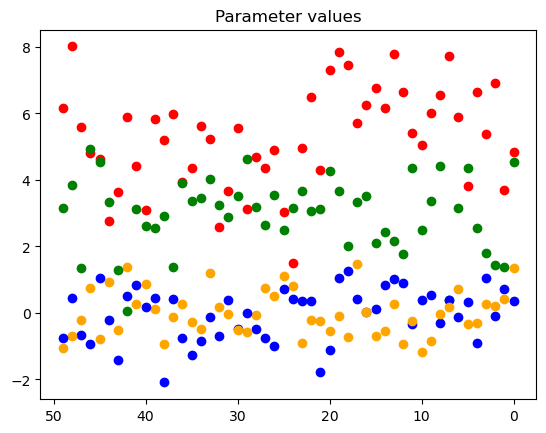

In [18]:
import matplotlib.pyplot as plt

colors = ['red', 'green', 'blue', 'orange'] # [theta_0, theta_1, theta_2, theta_3]

for i in range(50):
    for j in range(4):
        plt.scatter(i, params[i, j].item(), color=colors[j])
plt.gca().invert_xaxis()
plt.title('Parameter values')
plt.show()

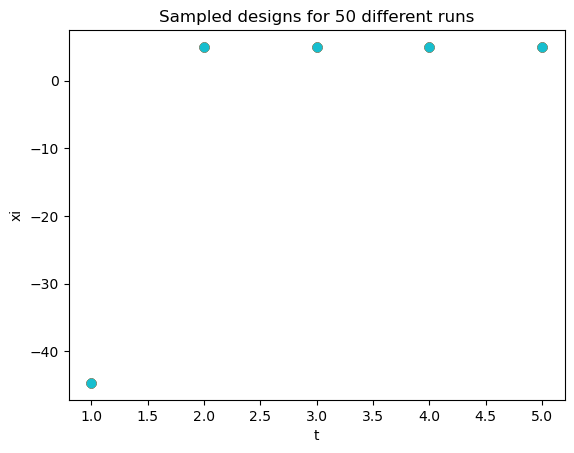

In [19]:
for t in range(len(designs)):
    for i in range(50):
        plt.scatter(t + 1, designs[t][i].detach().numpy())
plt.xlabel("t")
plt.ylabel("xi")
plt.title("Sampled designs for 50 different runs")
plt.show()